# **Part 2: Genres and communities and plotting**

## 1) Write about genres and modularity.
**Answer:** 
Modularity evaluates how well a network is divided into communities by comparing how densely connected nodes are within the same group versus between different groups. In this case, genre labels extracted from the artists’ Wikipedia infoboxes are used to form the partitions. The modularity value lies between 0 and 1, where higher values indicate that the partition reflects a meaningful community structure, and lower values indicate a weak correspondence. A high modularity would therefore suggest that genre categories align closely with the underlying structure of the network, while a low modularity would suggest that genre is not a strong indicator of how the artists are actually organized within the network.

## 2) Detect the communities, discuss the value of modularity in comparison to the genres.

In [1]:
import pickle
import requests
import networkx as nx
import numpy as np
import pandas as pd
import re
import random
from collections import defaultdict
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm



# Download and load dataset
url = "https://raw.githubusercontent.com/Emmsiiii/Assignment-2---02805-Social-Graphs-and-Interactions/main/rock_performers_with_genres-2.pkl"
filename = "rock_performers_with_genres-2.pkl"

response = requests.get(url)
with open(filename, "wb") as f:
    f.write(response.content)

with open(filename, "rb") as f:
    data = pickle.load(f)

# Clean genres 
for entry in data:
    raw = entry.get("genre", "")
    genres = re.split(r"[;,/\n]+|\s{2,}", raw.lower().strip())
    entry["genres"] = [g.strip() for g in genres if g.strip()]

# Build undirected graph 
G = nx.Graph()
names = {d["page_name"] for d in data}
genre_map = {d["page_name"]: d["genres"] for d in data}

for entry in data:
    src = entry["page_name"]
    content = entry["content"].lower()
    G.add_node(src, genres=genre_map.get(src, []))
    for tgt in names:
        if src != tgt and tgt.lower() in content:
            G.add_edge(src, tgt)

# Largest connected component 
G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

#Filter nodes with genres 
G_genre = G.subgraph([n for n in G.nodes if G.nodes[n].get("genres")]).copy()

# Helper for modularity 
def compute_modularity(graph, partition_dict):
    communities = list(partition_dict.values())
    L = graph.number_of_edges()
    Q = 0
    for community in communities:
        subG = graph.subgraph(community)
        Lc = subG.number_of_edges()
        kc = sum(dict(graph.degree(community)).values())
        Q += Lc / L - (kc / (2 * L))**2
    return Q

# Modularity by first genre
partition_first = defaultdict(set)
for node in G_genre.nodes:
    first = G_genre.nodes[node]["genres"][0]
    partition_first[first].add(node)

mod_first = compute_modularity(G_genre, partition_first)

# Modularity by first non-rock genre 
partition_non_rock = defaultdict(set)
for node in G_genre.nodes:
    non_rock = next((g for g in G_genre.nodes[node]["genres"] if g != "rock"), G_genre.nodes[node]["genres"][0])
    partition_non_rock[non_rock].add(node)

mod_non_rock = compute_modularity(G_genre, partition_non_rock)

# Modularity by random genre 
partition_random = defaultdict(set)
for node in G_genre.nodes:
    rnd = random.choice(G_genre.nodes[node]["genres"])
    partition_random[rnd].add(node)

mod_random = compute_modularity(G_genre, partition_random)

# Modularity by alphabetical genre 
partition_alpha = defaultdict(set)
for node in G_genre.nodes:
    sorted_genres = sorted(G_genre.nodes[node]["genres"])
    if sorted_genres:
        alpha = sorted_genres[0]
        partition_alpha[alpha].add(node)

mod_alpha = compute_modularity(G_genre, partition_alpha)

# Louvain communities 
communities_louvain = louvain_communities(G_genre, seed=42)
mod_louvain = modularity(G_genre, communities_louvain)

# Output results 
print(f"Modularity (First genre):       {mod_first:.4f}")
print(f"Modularity (Non-rock genre):    {mod_non_rock:.4f}")
print(f"Modularity (Random genre):      {mod_random:.4f}")
print(f"Modularity (Alphabetical genre):{mod_alpha:.4f}")
print(f"Modularity (Louvain):           {mod_louvain:.4f}")
print(f"Number of Louvain communities:  {len(communities_louvain)}")


Modularity (First genre):       0.0484
Modularity (Non-rock genre):    0.0438
Modularity (Random genre):      0.0142
Modularity (Alphabetical genre):0.0963
Modularity (Louvain):           0.3355
Number of Louvain communities:  7


**Answer:**  The modularity values show a clear distinction between data-driven community detection (Louvain) and genre-based partitions. The Louvain algorithm produce a modularity of 0.3355, which is substantially higher than any of the genre-based partitionings. This suggests that the communities detected by the network structure better capture the actual grouping of artists than genre labels do.
Among the genre-based approaches, using the alphabetically first genre performs best with a modularity of 0.0963, while the first listed genre and first non-rock genre produce a lower modularities around 0.0484 and 0.0438. The random genre baseline performs worst, with a modularity of only 0.0142, serving as a useful control.
These results indicate that while genre does contain some information about how artists are grouped, it is a weak signal in comparison to the patterns found directly in the network. Genre labels may be noisy, overlapping, or inconsistent across artists. Moreover, artists are often associated with multiple genres, which complicates any partitioning based solely on genre metadata.
In contrast, the Louvain method identifies 7 communities based entirely on the structure of connections between artists. The relatively high modularity score suggests that these structural communities are well-defined and capture real clustering behavior in the network, reflecting shared influences, collaborations, or cultural proximity beyond genre labels.

## 3) Calculate the matrix D and discuss your findings.


D: Confusion Matrix (Top Genres vs Louvain Communities):


,0,1,2,3,4,5,6
alternative rock,33,2,22,8,2,3,40
hard rock,37,3,1,26,3,16,13
pop rock,7,3,16,3,4,5,26
alternative metal,32,0,2,14,3,2,2
rock,2,6,0,4,2,4,24
heavy metal,6,0,1,21,1,7,3
post-grunge,25,0,2,4,0,2,5
pop,0,2,3,3,0,2,18
blues rock,3,0,0,7,1,4,12
pop-punk,1,0,14,1,0,0,6


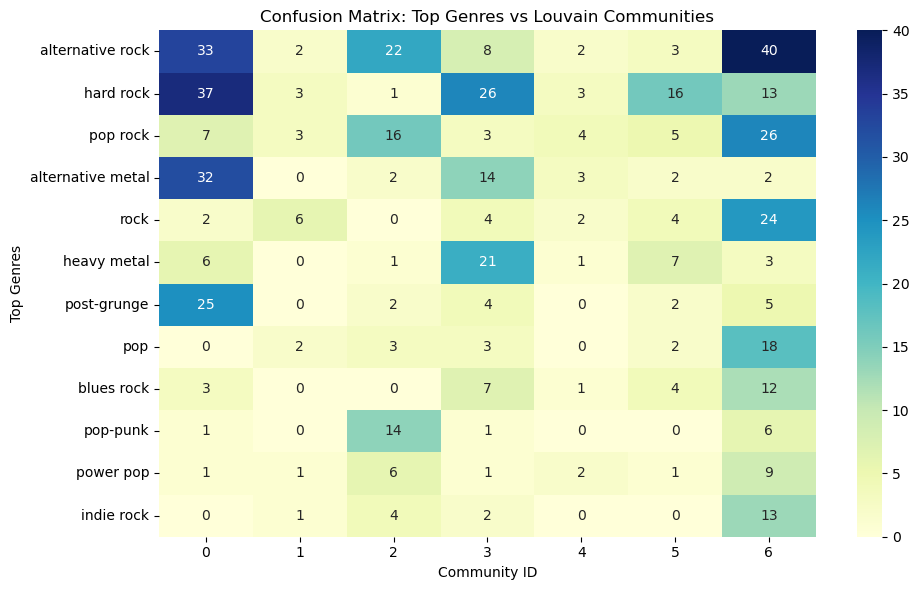

In [2]:
# Convert Louvain result → node → community id
node_to_community = {}
for i, comm in enumerate(communities_louvain):
    for node in comm:
        node_to_community[node] = i

# Build genre dictionary from graph attributes
genres_dict = {node: G_genre.nodes[node]["genres"] for node in G_genre.nodes}

# Count genre frequencies overall
genre_counts = {}
for node in G_genre.nodes:
    for g in genres_dict[node]:
        genre_counts[g] = genre_counts.get(g, 0) + 1

# Select the most common genres 
top_genres = sorted(genre_counts, key=genre_counts.get, reverse=True)[:12]

# Initialize matrix D with zeros
conf_matrix = pd.DataFrame(
    0,
    index=top_genres,
    columns=range(len(communities_louvain))
)

# Fill matrix (count how many bands of each genre land in each community)
for node in G_genre.nodes:
    comm = node_to_community[node]
    for g in genres_dict[node]:
        if g in top_genres:
            conf_matrix.loc[g, comm] += 1

print("\nD: Confusion Matrix (Top Genres vs Louvain Communities):")
display(conf_matrix)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix: Top Genres vs Louvain Communities")
plt.xlabel("Community ID")
plt.ylabel("Top Genres")
plt.tight_layout()
plt.show()


**Answer:** The confusion matrix compares the top genres with the Louvain-detected communities and shows how many artists from each genre fall into each community. Overall, genres are spread across multiple communities rather than being isolated to single groups. For example, alternative rock appears broadly across communities, but is most strongly represented in Community 0 and Community 6, indicating that genre alone does not fully determine community membership. Some genres do show partial alignment with the network structure. Hard rock is most concentrated in Communities 0 and 3, while heavy metal appears predominantly in Community 3, suggesting that these genres form more tightly connected sub-networks. In contrast, broad categories such as rock and pop are widely scattered across communities, which is expected because these labels cover many stylistic variations. The Louvain communities are derived from actual network connections, such as collaboration, influence, shared band members, or historical ties, rather than genre metadata. Therefore, they capture meaningful structural relationships that genre labels cannot fully represent. This aligns with the modularity results, where the Louvain partition achieved a higher modularity score than the genre-based partition, indicating that the network’s internal structure provides a better explanation for how artists cluster than genre categories alone.


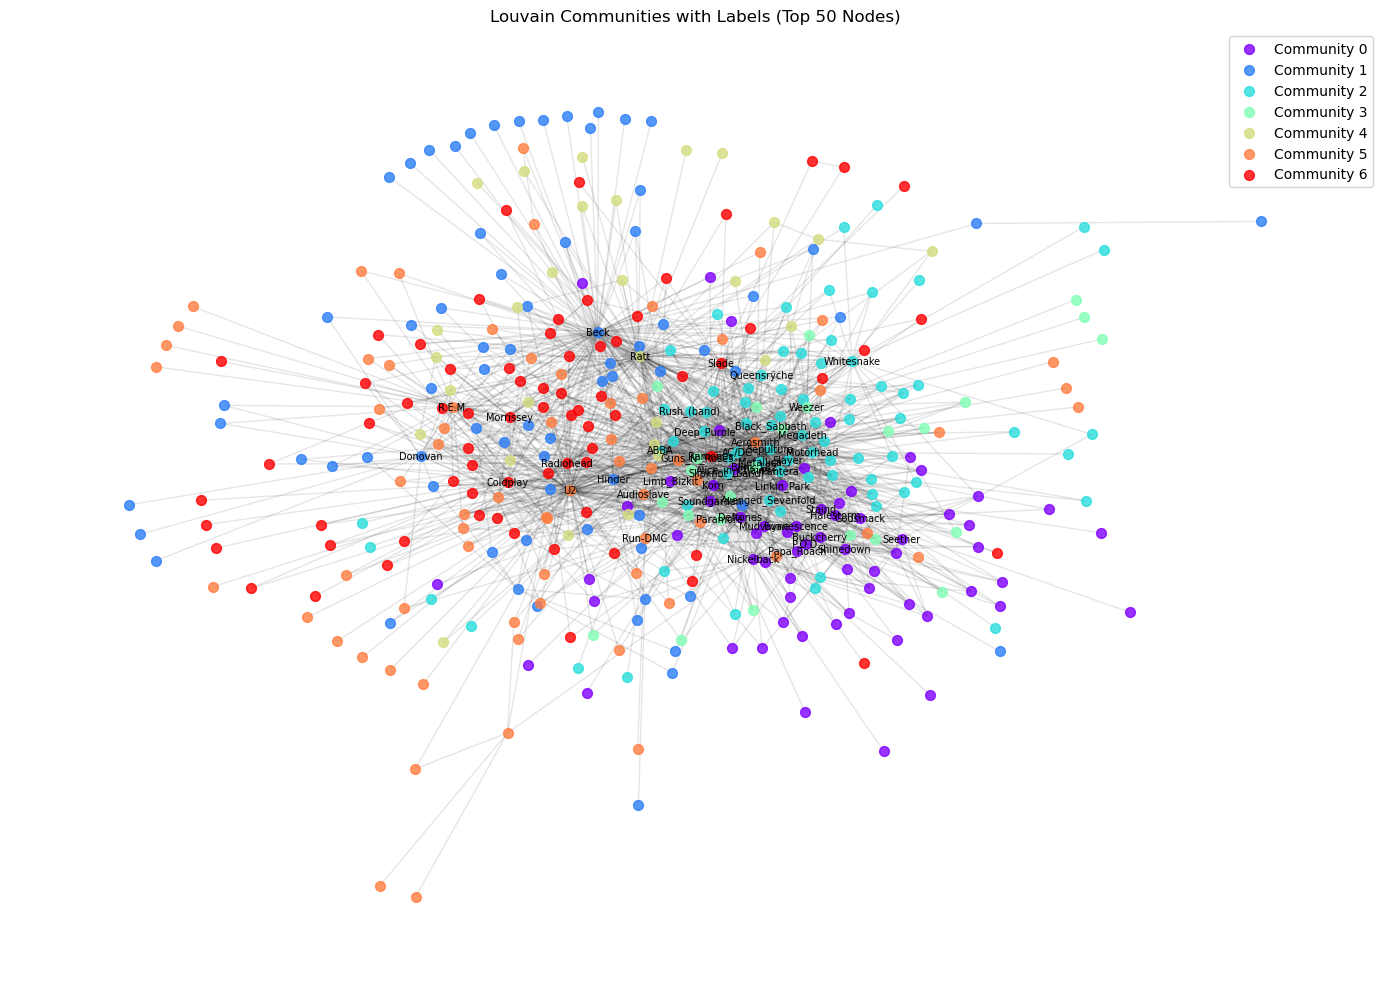

In [3]:
# Set community as node attribute
community_map = {}
for i, community in enumerate(communities_louvain):
    for node in community:
        community_map[node] = i
nx.set_node_attributes(G_genre, community_map, "community")

# Layout for consistent positioning
pos = nx.spring_layout(G_genre, seed=42)

# Color map
num_comms = len(communities_louvain)
colors = cm.rainbow(np.linspace(0, 1, num_comms))

# Plot
plt.figure(figsize=(14, 10))
for i, community in enumerate(communities_louvain):
    nx.draw_networkx_nodes(
        G_genre,
        pos,
        nodelist=community,
        node_color=[colors[i]],
        label=f"Community {i}",
        node_size=50,
        alpha=0.8
    )

# Draw edges
nx.draw_networkx_edges(G_genre, pos, alpha=0.1)

# Draw label (top 50 high-degree nodes to avoid clutter)
degrees = dict(G_genre.degree())
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:50]
labels = {node: node for node in top_nodes}
nx.draw_networkx_labels(G_genre, pos, labels=labels, font_size=7, font_color="black")

plt.title("Louvain Communities with Labels (Top 50 Nodes)")
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()


## 4) Plot the communities and comment on your results.

**Answer:** The plotted graph illustrates the Louvain-detected communities within the rock artist network. Each node represents an artist, and nodes are colored based on their assigned community. The 50 highest-degree nodes (most connected) are labeled to indicate key representatives of each cluster.
- Clear clustering: Distinct color groupings confirm that the Louvain algorithm successfully partitions the graph into structurally meaningful communities. These clusters are tightly packed, indicating high intra-community connectivity.
- Community boundaries: While the core of the network appears densely connected, peripheral nodes tend to form more isolated clusters, often corresponding to niche subgenres or localized influences.
- Overlap and blending: Some communities are visually interconnected, suggesting that artists span multiple genres or share broad connections. This supports earlier findings that genres do not perfectly align with structural communities.
- Influential nodes: Many of the labeled nodes (for example, Radiohead, Coldplay, Run-DMC, Beck) are highly connected, likely acting as bridges between communities. Their presence near the center reinforces their importance in the global network structure.
- Community diversity: The fact that top-labeled artists appear in multiple communities reflects genre fluidity in the rock domain, with artists often associated with multiple styles over time.

Overall, the visual confirms that the Louvain algorithm captures meaningful structural patterns, though these do not always align with genre-based classifications, further emphasizing that real-world artist relationships are more complex than genre labels alone can express.

# **Part 3) TF-IDF to understand genres and communities**

## 1) Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

**Answer:** TF-IDF (Term Frequency–Inverse Document Frequency) is a statistical weighting measure used in information retrieval and text analysis to evaluate the relative importance of a term within a particular document. The term frequency component captures how frequently a word appears in a document, reflecting its relevance within that specific text. The inverse document frequency component adjust this weight by penalizing words that are common across many documents, since such terms are less useful for distinguishing one document from another.
By combining these two components, TF-IDF assigns higher scores to words that occur frequently in a given document but are relatively uncommon in the wider collection of documents. This makes TF-IDF especially valuable for tasks such as document classification, topic identification, and clustering.
In the context of analyzing genres and communities, TF-IDF helps highlight terms that are particularly characteristic of each group. Because it emphasizes distinctive vocabulary rather than simply frequent vocabulary, it allows us to identify meaningful linguistic patterns or thematic signals that differentiate one genre or community from another. This supports deeper interpretation, comparison, and explanation of similarities and differences between groups. 

## 2) Calculate and visualize TF-IDF for the genres and communities.


### TOP TF-IDF WORDS — COMMUNITIES (Top Words) ###



,Community 0,Community 1,Community 2,Community 3,Community 4,Community 5,Community 6
0,cornell,adams,lavigne,black_sabbath,manson,gabriel,morrissey
1,soundgarden,clapton,weezer,osbourne,ronstadt,dylan,costello
2,evanescence,harrison,fall_out_boy,slayer,reznor,whitesnake,mccartney
3,linkin_park,badfinger,paramore,abba,kid_rock,vai,bowie
4,breaking_benjamin,nilsson,horizon,slade,rammstein,orbison,radiohead
5,godsmack,the_band,rise_against,megadeth,cocker,nugent,beck
6,incubus,springsteen,arcade_fire,mustaine,duran_duran,lennon,mellencamp
7,skillet,10cc,offspring,zappa,nine_inch_nails,amburn,petty
8,alter_bridge,oasis,hoppus,mot,limp_bizkit,richard,mayer
9,tley,benatar,delonge,rhead,chapin,collins,morrison



### TOP TF-IDF WORDS — GENRES (Top Words) ###



,alternative metal,alternative rock,groove metal,hard rock,heavy metal,indie rock,new wave,nu metal,pop rock,pop-punk,post-grunge,progressive rock,punk rock,rock
0,evanescence,weezer,pantera,whitesnake,osbourne,the_strokes,ant,limp_bizkit,fleetwood_mac,lavigne,nickelback,pink_floyd,ramones,mccartney
1,primus,coldplay,anselmo,coverdale,metallica,rubble,inxs,korn,monkees,fall_out_boy,daughtry,waters,clash,clapton
2,lee,beck,lamb,nugent,black_sabbath,ritz,blondie,slipknot,duran_duran,paramore,creed,genesis,green_day,costello
3,claypool,buckley,sepultura,aerosmith,mot,foals,sting,durst,rea,bowling,bush,rush,social_distortion,springsteen
4,deftones,muse,five_finger_death_punch,kiss,rhead,mfrom,talking_heads,borland,mcvie,hoppus,stapp,gilmour,offspring,joel
5,godsmack,scope,white_zombie,van_halen,cr,modest_mouse,stein,saliva,panic,delonge,doors_down,anderson,mclaren,petty
6,faith_no_more,garbage,god,slash,tley,vampire_weekend,copeland,jordison,valli,soup,gontier,banks,afi,mayer
7,mudvayne,linkin_park,max,dc,iommi,arctic_monkeys,harry,devenish21,nesmith,simple_plan,hinder,barrett,sex_pistols,byrds
8,moreno,corgan,rockmusic,simmons,dio,chaospin,the_police,lethal,buckingham,sum,seether,jethro_tull,strummer,nilsson
9,staind,morissette,kisser,ac,iron_maiden,koenig,summers,crahan,four_seasons,reddick,three_days_grace,gabriel,ness,beach_boys


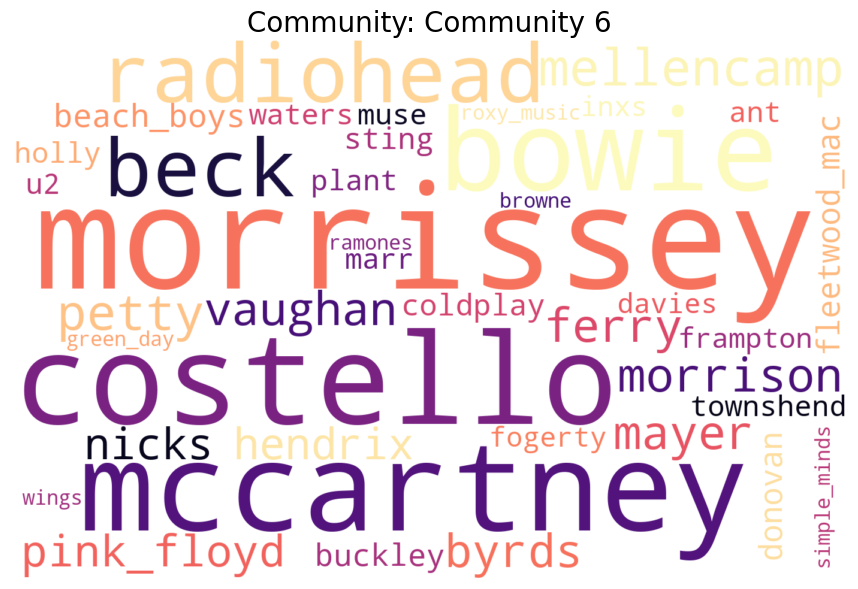

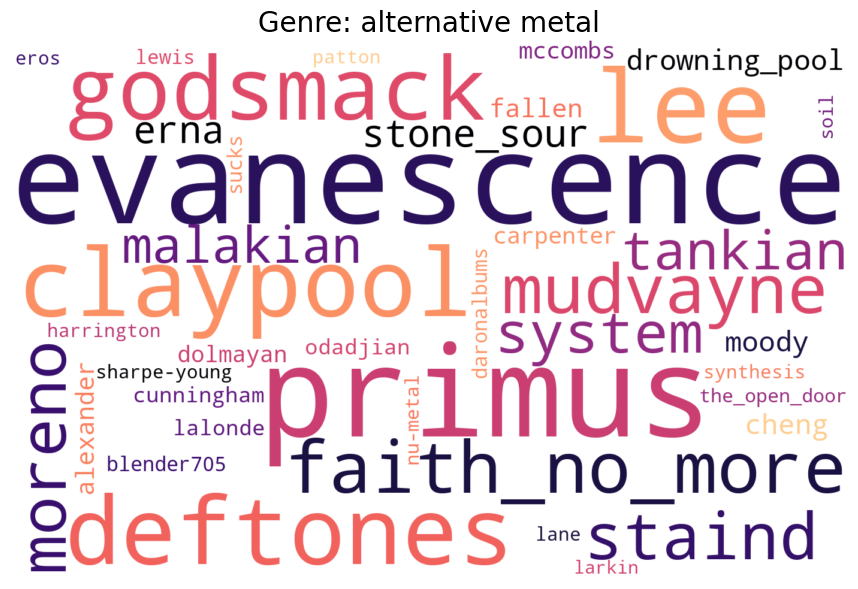

In [3]:
import re, numpy as np, pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Text Cleaning
def merge_proper_names(text):
    pattern = re.compile(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)+)\b")
    return pattern.sub(lambda m: m.group(1).replace(" ", "_"), text)

def clean_text(txt):
    txt = merge_proper_names(txt)
    txt = txt.lower()
    txt = re.sub(r"\{\{.*?\}\}", " ", txt)
    txt = re.sub(r"\[\[.*?\]\]", " ", txt)
    txt = re.sub(r"http\S+|www\.\S+", " ", txt)
    txt = re.sub(r"[^a-z0-9_\-\s]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

cleaned_text = {d["page_name"]: clean_text(d["content"]) for d in data}



# Corpus Builder

def create_corpus(groups, filter_n=5):
    corpus = {}
    for label, nodes in groups.items():
        text = " ".join(cleaned_text.get(n, "") for n in nodes)
        tokens = re.findall(r"[a-z0-9_\-]+", text)
        counts = Counter(tokens)
        counts = {w:c for w,c in counts.items() if c >= filter_n}
        corpus[label] = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    return corpus


# Compute TF-IDF


def compute_tfidf(corpus):
    df = Counter()
    for doc in corpus.values():
        for w,_ in doc:
            df[w] += 1

    N = len(corpus) + 1e-9
    scored = {}

    for label, doc in corpus.items():
        total = sum(c for _,c in doc) + 1e-9
        scored[label] = sorted(
            [(w, c, (c/total) * np.log(N / df[w])) for w,c in doc],
            key=lambda x: x[2],
            reverse=True
        )
    return scored



# Communities (Louvain)

community_groups = {f"Community {i}": set(comm) for i,comm in enumerate(communities_louvain)}
comm_corpus = create_corpus(community_groups, filter_n=5)
comm_tfidf = compute_tfidf(comm_corpus)



# Genres

def clean_genres(glist):
    items=[]
    for g in glist:
        for p in re.split(r"[,\n/;]", g.lower()):
            p = p.strip()
            if p: items.append(p)
    seen=set(); result=[]
    for g in items:
        if g not in seen:
            seen.add(g); result.append(g)
    return result

df_gen=[]
for node in G_genre.nodes:
    gs = clean_genres(G_genre.nodes[node]["genres"])
    if gs:
        df_gen.append((node, gs[0]))

df_gen = pd.DataFrame(df_gen, columns=["artist","genre"])
genre_groups = df_gen.groupby("genre")["artist"].apply(set)
genre_groups = {g:n for g,n in genre_groups.items() if len(n)>=5}

genre_corpus = create_corpus(genre_groups, filter_n=5)
genre_tfidf = compute_tfidf(genre_corpus)



# Display TF-IDF Tables


def top_tfidf_table(scored, title, k=10):
    print(f"\n### TOP TF-IDF WORDS — {title} ###\n")
    df = pd.DataFrame({label: [w for (w,_,_) in lst[:k]] for label,lst in scored.items()})
    display(df)

top_tfidf_table(comm_tfidf, "COMMUNITIES (Top Words)")
top_tfidf_table(genre_tfidf, "GENRES (Top Words)")



# Word Cloud Visualization


def wordcloud(label, scored_list, title, max_words=40):
    freq = {w:score for (w,_,score) in scored_list[:max_words]}
    wc = WordCloud(width=1400, height=900, background_color="white", colormap="magma")
    wc = wc.generate_from_frequencies(freq)

    plt.figure(figsize=(11,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{title}: {label}", fontsize=20)
    plt.show()



wordcloud("Community 6", comm_tfidf["Community 6"], "Community")


first_genre = list(genre_tfidf.keys())[0]
wordcloud(first_genre, genre_tfidf[first_genre], "Genre")




## 3) Use the matrix D (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

**Answer** Using the matrix D to compare genres with communities shows that the two organization principles capture different underlying structures in the network. The TF-IDF genre word-clouds emphasize stylistic identity: the highest-weighted terms tend to be names of key artists, albums, or musical signifiers that clearly characterize the sound of the genre. In contrast, the community word-clouds do not group artists based on musical similarity but instead reflect the structural relationships in the network, such as shared band members, collaboration histories, or co-occurrence in musical projects. This is also visible in the confusion matrix, where most genres are spread across several communities rather than aligning with a single one, indicating that stylistic labels do not map cleanly onto collaboration clusters. As a result, the genre word-clouds are more cohesive and semantically interpretable in terms of musical style, while the community word-clouds often mix artists across genres, revealing social and historical linkages rather than aesthetic ones. Together, these results show that TF-IDF provides two complementary perspectives: genres describe what the music is, whereas communities describe how artists are connected in the cultural network.